In [3]:
# colab
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
# colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#colab
# import os
# assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
#colab
# VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

In [5]:
# colab
!pip install fastai2 --upgrade > /dev/null

In [10]:
#colab
!pip install git+https://github.com/butchland/fastai_xla_extensions

  Cloning https://github.com/butchland/fastai_xla_extensions to /tmp/pip-req-build-edm9sh3e
  Running command git clone -q https://github.com/butchland/fastai_xla_extensions /tmp/pip-req-build-edm9sh3e
     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for fastai-xla-extensions: filename=fastai_xla_extensions-0.0.1-cp36-none-any.whl size=10373 sha256=de698de6067cfad7b5946b8725c9b7518688a4776128e32375ac64963df0d63b
  Stored in directory: /tmp/pip-ephem-wheel-cache-etdsg8lo/wheels/3c/d5/c1/7a96c15b4e74b5d1ec0bc6c29fcaf36501791ce2d9a88a8cea
Successfully built fastai-xla-extensions


In [6]:
#colab
!pip install git+https://github.com/butchland/my_timesaver_utils

  Cloning https://github.com/butchland/my_timesaver_utils to /tmp/pip-req-build-mmakjkh0
  Running command git clone -q https://github.com/butchland/my_timesaver_utils /tmp/pip-req-build-mmakjkh0
  Created wheel for my-timesaver-utils: filename=my_timesaver_utils-0.0.1-cp36-none-any.whl size=9098 sha256=65f22998650b6cd6ef52315815c836939b2015ca2d6672cd8c71331bb78701c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-egjmf1si/wheels/ca/6d/f4/ad01bd19bc4c102a3851d9c636dc2a2031d97b98cb9a73effa
Successfully built my-timesaver-utils


### Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai2.vision.all import *

In [3]:
from fastai_xla_extensions.core import *

In [4]:
from my_timesaver_utils.profiling import *

### Setup data

In [5]:
path = untar_data(URLs.PETS)/'images'

### Loop through batch and walk through batch transforms

In [ ]:
# from IPython.core.debugger import set_trace

In [ ]:
# TRACE = True

In [6]:
orig_randtransform_call = RandTransform.__call__
def __call__(self, b, split_idx=None, **kwargs):
    is_affine_tfm = isinstance(self, AffineCoordTfm)
    if is_affine_tfm:
#         print(f'applying AffineCoordTfm call {self}')
#         if TRACE: set_trace()
        start_record('affine_tfm_call')
    results = orig_randtransform_call(self, b, split_idx, **kwargs)
    if is_affine_tfm:
        end_record('affine_tfm_call')
    return results

In [7]:
setattr(RandTransform,'__call__', __call__)

In [ ]:
# def mycompose_tfms(x, tfms, is_enc=True, reverse=False, **kwargs):
#     "Apply all `func_nm` attribute of `tfms` on `x`, maybe in `reverse` order"
#     if reverse: tfms = reversed(tfms)
#     for f in tfms:
#         if not is_enc: f = f.decode
#         if isinstance(f,AffineCoordTfm): 
#             print(f'applying {type(f)} {f} to {type(x)}')
#             if TRACE:
#                 set_trace()
#         x = f(x, **kwargs)
#     return x


In [ ]:
# @patch_to(Pipeline)
# def __call__(self, o): return mycompose_tfms(o, tfms=self.fs, split_idx=self.split_idx)

In [16]:
# TRACE = False

In [8]:
batch_tfms = aug_transforms(max_zoom=1.1, max_warp=0., max_rotate=0., max_lighting=0.0,do_flip=False)
batch_tfms

[AffineCoordTfm: (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes ]

In [9]:
batch_tfms[0].aff_fs

(#1) [functools.partial(<function zoom_mat at 0x7f73f652fa60>, max_zoom=1.1, p=0.75, draw=None, draw_x=None, draw_y=None, batch=False)]

In [10]:
batch_tfms[0].coord_fs

(#0) []

In [11]:
pat = r'(.+)_\d+.jpg$'

Create Fastai DataBlock


_Note that batch transforms are currently
set to none as they seem to slow the training
on the TPU (for investigation)._

In [12]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(pat),'name'),
    item_tfms=Resize(224),
    batch_tfms=batch_tfms
   
)

In [13]:
print_prof_data()

In [14]:
datablock.summary(path)

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/keeshond_181.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=333x500
  Pipeline: partial -> Categorize
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/keeshond_181.jpg
    applying partial gives
      keeshond
    applying Categorize gives
      TensorCategory(24)

Final sample: (PILImage mode=RGB size=333x500, TensorCategory(24))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> AffineCoordTfm

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=333x500, TensorCategory(24))
    applying Resize gives


In [15]:
print_prof_data()

Function affine_tfm_call called 2 times.
Execution time max: 0.221, average: 0.113


### Setup DataLoaders

In [16]:
bs=256

In [17]:
dls = datablock.dataloaders(path,bs=bs)

In [18]:
dls.train

In [21]:
train_dl = dls.train

In [ ]:
# def fetch_one_batch():
#     if TRACE: set_trace()
#     dl_iter = train_dl.__iter__()
#     b = dl_iter.__next__()

In [ ]:
# TRACE = False

In [19]:
clear_prof_data();print_prof_data()

In [ ]:
# fetch_one_batch()

In [ ]:
# print_prof_data()

In [ ]:
clear_prof_data(); print_prof_data()

In [20]:
def fetch_all_batches():
    for b in train_dl:
        pass

In [22]:
fetch_all_batches()

In [23]:
print_prof_data()

Function affine_tfm_call called 23 times.
Execution time max: 0.059, average: 0.046


In [24]:
times = get_prof_data('affine_tfm_call')

In [25]:
import matplotlib.pyplot as plt

In [26]:
times

[0.053734540939331055,
 0.04523611068725586,
 0.04570794105529785,
 0.04537177085876465,
 0.05934262275695801,
 0.0493016242980957,
 0.05890250205993652,
 0.044521331787109375,
 0.0428922176361084,
 0.044544219970703125,
 0.042526960372924805,
 0.04255938529968262,
 0.04249715805053711,
 0.04248523712158203,
 0.05049943923950195,
 0.05124211311340332,
 0.04971623420715332,
 0.04436469078063965,
 0.04828596115112305,
 0.03904414176940918,
 0.03916788101196289,
 0.03891944885253906,
 0.03831744194030762]

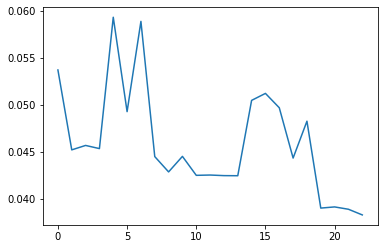

In [28]:
plt.plot(times);

In [29]:
dls.device

device(type='cuda', index=0)

In [30]:
train_dl.device

device(type='cuda', index=0)